In [323]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn


In [324]:
# Load in data
data = torch.load('preprocessed_data.pt')
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
sample_weights = data['sample_weights']


In [ ]:
# Define LSTM, adapted from COMP534

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, bidirectional=True, dropout_p=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # regression output

    def forward(self, x):
        out, _ = self.lstm(x)
        last_time_step_out = out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out.squeeze()


In [326]:
# Define weighted MSE loss function to address  data imbalance.
def weighted_mse_loss(predictions, targets, weights):
    return torch.mean(weights * (predictions - targets) ** 2)

In [327]:
# Initialse dataloaders using the train, validate and test datasets respectively.

from torch.utils.data import Dataset, DataLoader

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class WeightedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, weights=None):
        self.X = X
        self.y = y
        self.weights = weights if weights is not None else torch.ones(len(X))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

# Use the weighted dataset for training
train_dataset = WeightedSequenceDataset(X_train, y_train, sample_weights)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [328]:
test_dataset = SequenceDataset(X_test, y_test)
val_dataset = SequenceDataset(X_val, y_val)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)


In [329]:
# Initialise model and initial parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]  # number of SHARP features
model = LSTMModel(input_size=input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [330]:
# Train the model, printing loss and validation loss per epoch.

num_epochs = 200

best_val_loss = float('inf')
patience = 100
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch, w_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        w_batch = w_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = weighted_mse_loss(outputs, y_batch, w_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation (no weights)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = nn.functional.mse_loss(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter on improvement
    else:
        counter += 1
        print(f'Validation loss increased ({val_loss:.4f}), patience {counter}/{patience}')
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/200 - Train Loss: 0.0731 - Val Loss: 6.8445
Epoch 2/200 - Train Loss: 0.0532 - Val Loss: 9.0253
Validation loss increased (9.0253), patience 1/100
Epoch 3/200 - Train Loss: 0.0480 - Val Loss: 5.0464
Epoch 4/200 - Train Loss: 0.0414 - Val Loss: 5.0122
Epoch 5/200 - Train Loss: 0.0386 - Val Loss: 4.4074
Epoch 6/200 - Train Loss: 0.0374 - Val Loss: 3.9617
Epoch 7/200 - Train Loss: 0.0360 - Val Loss: 4.7652
Validation loss increased (4.7652), patience 1/100
Epoch 8/200 - Train Loss: 0.0346 - Val Loss: 9.9644
Validation loss increased (9.9644), patience 2/100
Epoch 9/200 - Train Loss: 0.0345 - Val Loss: 4.4629
Validation loss increased (4.4629), patience 3/100
Epoch 10/200 - Train Loss: 0.0337 - Val Loss: 4.7782
Validation loss increased (4.7782), patience 4/100
Epoch 11/200 - Train Loss: 0.0330 - Val Loss: 3.9082
Epoch 12/200 - Train Loss: 0.0331 - Val Loss: 4.9090
Validation loss increased (4.9090), patience 1/100
Epoch 13/200 - Train Loss: 0.0326 - Val Loss: 4.1909
Validation los

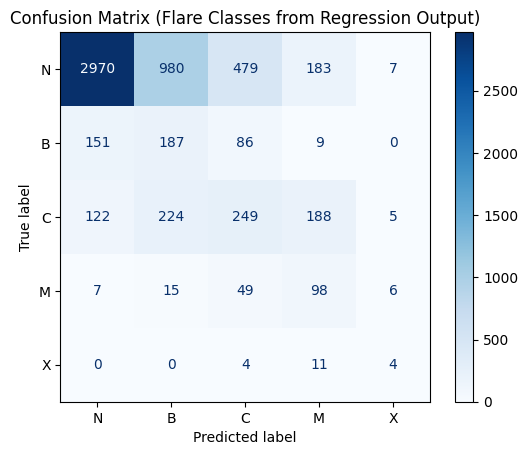

In [331]:
# Use classification to guage model performance, using confusion matrix for performance evauation on test set

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate model on test set
model.eval()
all_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        all_preds.extend(outputs.cpu().numpy())

y_pred = np.array(all_preds)
y_true = y_test.cpu().numpy() 
# Convert predictions and targets from log-scale to linear scale
y_pred_linear = 10 ** y_pred
y_true_linear = 10 ** y_true

# Define intensity bins for flare classes
bins = [0, 1e-7, 1e-6, 1e-5, 1e-4, np.inf]
labels = ['N', 'B', 'C', 'M', 'X']
class_indices = list(range(len(labels)))  # [0, 1, 2, 3, 4]

# Bin true and predicted values into classes
y_true_class = np.digitize(y_true_linear, bins) - 1
y_pred_class = np.digitize(y_pred_linear, bins) - 1

# Plot confusion matrix
unique_labels = sorted(np.unique(np.concatenate([y_true_class, y_pred_class])))
display_labels = [labels[i] for i in unique_labels]

cm = confusion_matrix(y_true_class, y_pred_class, labels=class_indices)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Flare Classes from Regression Output)")
plt.show()

